In [1]:
# imports
import numpy as np

# modelling
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os

In [2]:
# function to load and preprocess quickdraw data
def load_quickdraw_data(dir, category_name, n_samples=1000):
    file = f'full_numpy_bitmap_{category_name}.npy'
    data = np.load(dir + file)
    if n_samples == -1:
        return data
    else:
        indices = np.random.choice(len(data), n_samples, replace=False)
        sampled_data = data[indices]
        return sampled_data

In [3]:
def data_generator(data, batch_size=512):
    n_samples = len(data)
    for i in range(0, n_samples, batch_size):
        batch = data[i:i + batch_size]
        yield batch

In [4]:
files = os.listdir(r'..\data\\')
categories = [file.split('_')[-1].split('.')[0] for file in files]

In [5]:
# Directory where data files are stored
dir = '../data/'

# Load and preprocess data
all_data = []
labels = []

In [6]:
for category_name in categories:
    category_data = load_quickdraw_data(dir, category_name, 100) # Change this to -1 for all data
    all_data.extend(category_data)
    labels.extend([category_name] * len(category_data))

In [7]:
# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)

In [8]:
print(len(all_data))

34500


In [9]:
# normalize data
x_train = np.array(x_train).astype(np.float32) / 255
x_test = np.array(x_test).astype(np.float32) / 255

In [10]:
# Add Outliers
num_outliers = 500

# Generate random outliers
outliers = np.random.rand(num_outliers, 784)  # Assuming your data has 784 features

In [11]:
# Append outliers to your training data
x_train_with_outliers = np.vstack((x_train, outliers))

# Create labels for the outliers (e.g., label them as "outlier" or use a different category)
y_train_with_outliers = y_train + ['outlier'] * num_outliers

In [12]:
n_components = 10  # Adjust according to features needed
pca = PCA(n_components=n_components)

In [13]:
pca_results_train = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_train_with_outliers):
    batch_pca = pca.fit_transform(batch)
    if pca_results_train is None:
        pca_results_train = batch_pca
    else:
        pca_results_train = np.vstack((pca_results_train, batch_pca))

In [14]:
pca_results_test = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_test):
    batch_pca = pca.transform(batch)
    if pca_results_test is None:
        pca_results_test = batch_pca
    else:
        pca_results_test = np.vstack((pca_results_test, batch_pca))

In [15]:
# Shuffle the dataset after adding synthetic outliers
pca_results_train, y_train_with_outliers = shuffle(pca_results_train, y_train_with_outliers, random_state=42)

In [16]:
# Train Isolation Forest with outliers
model = IsolationForest(contamination=0.02, random_state=42)

train_data_generator = data_generator(pca_results_train)

for batch in train_data_generator:
    model.fit(batch)

In [17]:
# Predict labels for x_train_with_outliers to check if outliers are catched
y_pred_train = np.array([])  # Initialize an empty array to store predictions

for batch in data_generator(pca_results_train):
    batch_pred = model.predict(batch)
    y_pred_train = np.concatenate([y_pred_train, batch_pred])

# Map the predictions: 1 for outliers, 0 for inliers
y_pred_train[y_pred_train == 1] = 0  # Inliers
y_pred_train[y_pred_train == -1] = 1  # Outliers

y_train_numeric = [1 if label == 'outlier' else 0 for label in y_train_with_outliers]

In [18]:
# Evaluate the model's performance on training data
precision_train = precision_score(y_train_numeric, y_pred_train)
recall_train = recall_score(y_train_numeric, y_pred_train)
f1_train = f1_score(y_train_numeric, y_pred_train)

print("Training Data Classification Report:")
print(classification_report(y_train_numeric, y_pred_train, target_names=["inlier", "outlier"]))
print("Training Data Precision:", precision_train)
print("Training Data Recall:", recall_train)
print("Training Data F1 Score:", f1_train)

Training Data Classification Report:
              precision    recall  f1-score   support

      inlier       0.98      0.98      0.98     27600
     outlier       0.00      0.00      0.00       500

    accuracy                           0.96     28100
   macro avg       0.49      0.49      0.49     28100
weighted avg       0.96      0.96      0.96     28100

Training Data Precision: 0.0
Training Data Recall: 0.0
Training Data F1 Score: 0.0


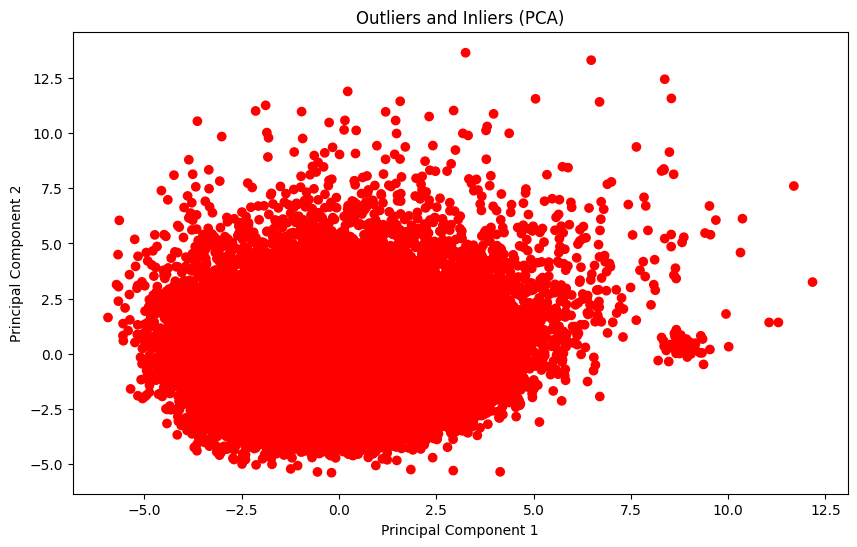

In [19]:
# Plot the data to visualize outliers and inliers using PCA-transformed data
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 'inlier' else 'red' for label in y_train_with_outliers]
plt.scatter(pca_results_train[:, 0], pca_results_train[:, 1], c=colors)
plt.title("Outliers and Inliers (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

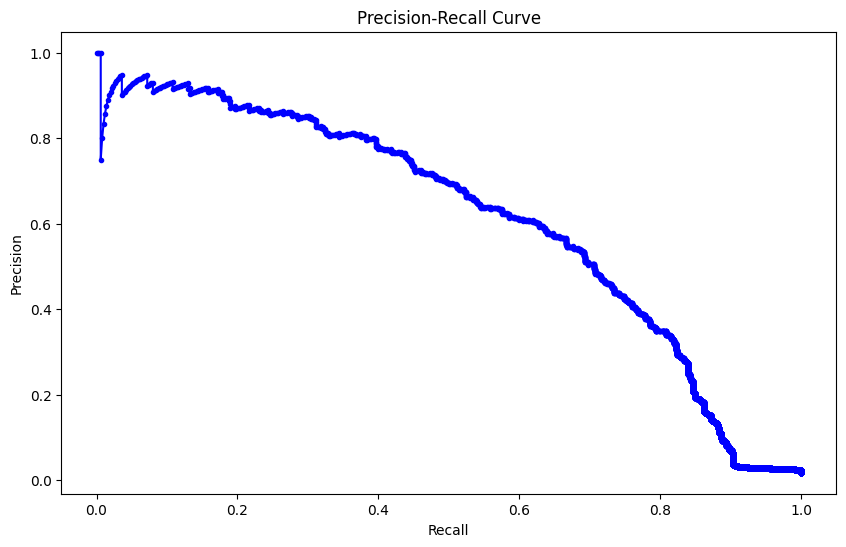

In [20]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_train_numeric, model.decision_function(pca_results_train))
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [21]:
# Predict outliers on the test set
test_data_generator = data_generator(pca_results_test)

# predict outliers on the test set
y_pred = np.array([])
for batch in test_data_generator:
    y_pred_batch = model.predict(batch)
    y_pred = np.concatenate([y_pred, y_pred_batch])

In [22]:
# Map the predictions: 1 for outliers, 0 for inliers
y_pred[y_pred == 1] = 0  # Inliers
y_pred[y_pred == -1] = 1  # Outliers

y_test_numeric = [1 if label == 'outlier' else 0 for label in y_test]

In [23]:
precision = precision_score(y_test_numeric, y_pred)
recall = recall_score(y_test_numeric, y_pred)
f1 = f1_score(y_test_numeric, y_pred)

c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [24]:
print("Classification Report:")
print(classification_report(y_test_numeric, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6900

    accuracy                           1.00      6900
   macro avg       1.00      1.00      1.00      6900
weighted avg       1.00      1.00      1.00      6900

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


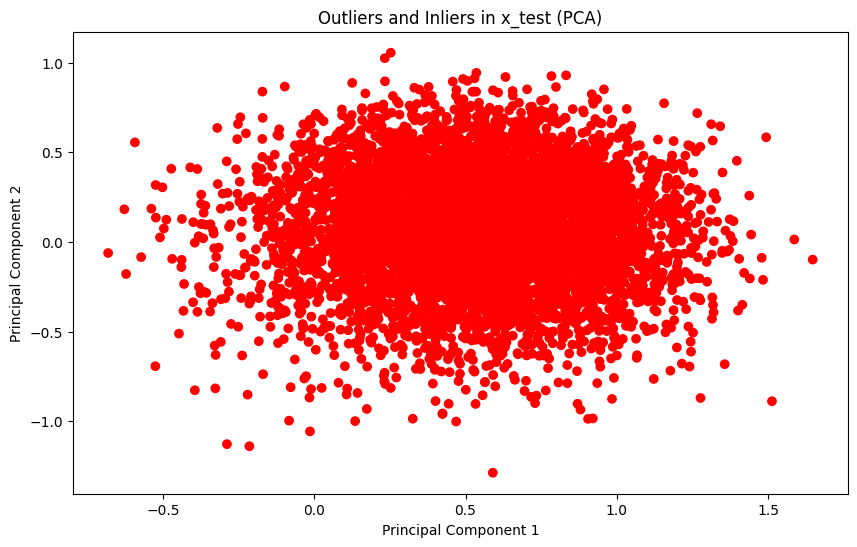

In [25]:
# Plot the data to visualize outliers and inliers using PCA-transformed data
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 'inlier' else 'red' for label in y_test]
plt.scatter(pca_results_test[:, 0], pca_results_test[:, 1], c=colors)
plt.title("Outliers and Inliers in x_test (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()